This is the second version of the modeling part. I know seek to predict IPO "failures" as opposed to "successes" in the v1.0 (the definition stayed the same, however). For more details see the discussion below. <br>

I also consider techniques to deal with the imbalanced classes (e.g. SMOTE). Plus, I test more models - in addition to GradientBoost, I introduce here Logistic Regression, RandomForest and AdaBoost.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from patsy import dmatrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import fbeta_score, recall_score, precision_score, accuracy_score, make_scorer
from  sklearn.model_selection import GridSearchCV

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_csv('data/ipo_stock_2010_2018_v2.csv', parse_dates=['Date Priced', 'year'])

In [3]:
print(df.shape)
df.head()

(834, 26)


,Company Name,Symbol,Market,Price,Shares,Offer Amount,Date Priced,employees,address,US_state,...,inmonth_open,inweek_adjclose,inweek_open,inyear_adjclose,inyear_open,sector,industry,employees2019,CEO_pay,CEO_born
0,ANDATEE CHINA MARINE FUEL SERVICES CORP,AMCF,NASDAQ,6.3,3134921.0,19750002.0,2010-01-26,128.0,NO. 68 BINHAI RD DALIAN XIGANG DISTRICTDALIAN ...,NaN,...,8.000000,5.830000,6.030000,2.720000,2.58,Energy,Oil & Gas Equipment & Services,189.0,NaN,NaN
1,GENERAC HOLDINGS INC.,GNRC,New York Stock Exchange,13.0,18750000.0,243750000.0,2010-02-11,1486.0,"S45 W29290 HIGHWAY 59WAUKESHA, WI 53187",WI,...,14.910000,8.612183,13.050000,13.415763,20.24,Industrials,Diversified Industrials,5046.0,2520000.0,1972.0
2,"QUINSTREET, INC",QNST,NASDAQ,15.0,10000000.0,150000000.0,2010-02-11,568.0,"950 TOWER LANE, 6TH FLOORFOSTER CITY, CA 94404",CA,...,16.010000,12.980000,13.500000,12.740000,12.52,Technology,Internet Content & Information,506.0,816150.0,1960.0
3,TERRENO REALTY CORP,TRNO,New York Stock Exchange,20.0,8750000.0,175000000.0,2010-02-10,6.0,"16 MAIDEN LANEFIFTH FLOORSAN FRANCISCO, CA 94108",CA,...,19.530001,14.770803,18.809999,13.518149,17.02,Real Estate,REIT - Industrial,23.0,799500.0,1961.0
4,"PIEDMONT OFFICE REALTY TRUST, INC.",PDM,New York Stock Exchange,14.5,12000000.0,174000000.0,2010-02-10,109.0,"5565 GLENRIDGE CONNECTORSTE 450ATLANTA, GA 30342",GA,...,19.299999,10.400203,17.830000,14.289856,21.02,Real Estate,REIT - Office,134.0,NaN,NaN


In [4]:
df.columns

Index(['Company Name', 'Symbol', 'Market', 'Price', 'Shares', 'Offer Amount',
       'Date Priced', 'employees', 'address', 'US_state', 'descriptions',
       'link_nasdaq', 'year', 'firstday_adjclose', 'firstday_open',
       'inmonth_adjclose', 'inmonth_open', 'inweek_adjclose', 'inweek_open',
       'inyear_adjclose', 'inyear_open', 'sector', 'industry', 'employees2019',
       'CEO_pay', 'CEO_born'],
      dtype='object')

In [5]:
keep_cols = ['Company Name', 'Price', 'Shares', 'Offer Amount',
       'Date Priced', 'employees', 'US_state', 'firstday_adjclose', 'firstday_open',
       'inmonth_adjclose', 'inweek_adjclose', 'sector', 'CEO_pay', 'CEO_born']

In [6]:
df = df[keep_cols]

In [7]:
#assigning to all companies that don't have US_state - foreign status
df['US_state'] = df['US_state'].apply(lambda x: 'foreign' if str(x) == 'nan' else x)

In [8]:
df['diff_close_inday_2_open_firstday'] = df['firstday_adjclose'] - df['firstday_open']

# Check for Typos in Prices

It turned out that Yahoo Finance has mistakes in historical data. I came to acknowledge this after comparing IPO offer price and scraped opening price on Yahoo Finance. The following code does just that - shows the companies where the discrepancies are higher than 2 times. I have checked few companies manually - the scraper scraped the correct data for correct company and date. However, when checked against news this Yahoo Finance data is indeed unreliable.So I decided to exclude these from the dataset.<br>

For instance, Blue Apron Inc went to IPO on 6/29/2017 with the offer price of \\$10. Yahoo Finance reports its price on 6/29/2017 as \\$150 (see also the pic below). In reality, however, it's opening and closing price was \\$10 (https://www.cnbc.com/2017/06/29/blue-apron-ipo-opening-trade.html)

<img src="assets/BlueApron_example.png" alt="drawing" height="1500" width="800"/>



In [9]:
df['check_prices'] = df['firstday_open']/df['Price']

In [10]:
typo_prices = df[(df['check_prices'] > 2) | (df['check_prices'] < -2)][['Company Name', 'Price', 'firstday_open','firstday_adjclose', 'inweek_adjclose']]

In [11]:
print(typo_prices.shape[0])
typo_prices.head()

47


,Company Name,Price,firstday_open,firstday_adjclose,inweek_adjclose
7,SCORPIO TANKERS INC.,13.0,127.500000,121.557602,120.686592
23,"ROADRUNNER TRANSPORTATION SYSTEMS, INC.",14.0,343.750000,343.750000,348.750000
36,"AMYRIS, INC.",16.0,247.500000,247.500000,256.049988
43,DAQO NEW ENERGY CORP.,9.5,49.900002,51.250000,67.000000
47,GLOBUS MARITIME LTD,11.6,476.000000,488.170715,497.734833


In [12]:
df = df.drop(typo_prices.index, axis=0)

In [13]:
df.reset_index(drop=True, inplace=True)

In [14]:
df.isna().sum()

Company Name                          0
Price                                 1
Shares                                1
Offer Amount                          0
Date Priced                           0
employees                            14
US_state                              0
firstday_adjclose                     0
firstday_open                         0
inmonth_adjclose                      0
inweek_adjclose                       0
sector                               10
CEO_pay                             214
CEO_born                             70
diff_close_inday_2_open_firstday      0
check_prices                          1
dtype: int64

In [15]:
#drop 1 row where there is no Offer Price
df.drop(df[df.Price.isna()].index, axis=0, inplace=True)

In [16]:
#drop 14 rows where there are no employees
df.drop(df[df.employees.isna()].index, axis=0, inplace=True)

In [17]:
#drop 10 rows where there is no sector
df.drop(df[df.sector.isna()].index, axis=0, inplace=True)

In [18]:
df.isna().sum()

Company Name                          0
Price                                 0
Shares                                0
Offer Amount                          0
Date Priced                           0
employees                             0
US_state                              0
firstday_adjclose                     0
firstday_open                         0
inmonth_adjclose                      0
inweek_adjclose                       0
sector                                0
CEO_pay                             198
CEO_born                             58
diff_close_inday_2_open_firstday      0
check_prices                          0
dtype: int64

In [19]:
#drop rows where there is no CEO_born
df.drop(df[df.CEO_born.isna()].index, axis=0, inplace=True)

In [20]:
#drop rows where there is no CEO_pay
df.drop(df[df.CEO_pay.isna()].index, axis=0, inplace=True)

In [21]:
df['y'] = df['diff_close_inday_2_open_firstday'].apply(lambda x: 1 if x >= 1 else 0)
df['y'].size

565

# Feature Engineering

### Weekday of the IPO day 

In [22]:
df['month'] = df['Date Priced'].map(lambda x: x.month)

In [23]:
df['month'] = df['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug',\
                                  9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})

In [24]:
df['weekday'] = df['Date Priced'].dt.dayofweek.map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})

In [25]:
df.shape

(565, 19)

In [26]:
df.head()

,Company Name,Price,Shares,Offer Amount,Date Priced,employees,US_state,firstday_adjclose,firstday_open,inmonth_adjclose,inweek_adjclose,sector,CEO_pay,CEO_born,diff_close_inday_2_open_firstday,check_prices,y,month,weekday
1,GENERAC HOLDINGS INC.,13.0,18750000.0,243750000.0,2010-02-11,1486.0,WI,8.460629,13.00,9.719180,8.612183,Industrials,2520000.0,1972.0,-4.539371,1.000000,0,Feb,Thu
2,"QUINSTREET, INC",15.0,10000000.0,150000000.0,2010-02-11,568.0,CA,15.000000,15.00,16.410000,12.980000,Technology,816150.0,1960.0,0.000000,1.000000,0,Feb,Thu
3,TERRENO REALTY CORP,20.0,8750000.0,175000000.0,2010-02-10,6.0,CA,14.692022,18.75,15.330121,14.770803,Real Estate,799500.0,1961.0,-4.057978,0.937500,0,Feb,Wed
6,SS&C TECHNOLOGIES HOLDINGS INC,15.0,10725000.0,160875000.0,2010-03-31,1253.0,CT,7.181165,8.00,7.957377,7.862139,Technology,10880000.0,1955.0,-0.818835,0.533333,0,Mar,Wed
8,FIRST INTERSTATE BANCSYSTEM INC,14.5,10000000.0,145000000.0,2010-03-24,1730.0,MT,11.994637,16.00,12.239342,12.331657,Financial Services,1710000.0,1960.0,-4.005363,1.103448,0,Mar,Wed


### Market Conditions

It makes sense to add broad market conditions approximized here by S&P500. If the general stock market was down, probably this will affect the IPO prices on the first day. So I take a market change a week before IPO date and construct a new feature SP_Week_Chg. 

In [27]:
sp = pd.read_csv('data/spy.csv')

In [28]:
# we need to have our Date values ordered 
#even if it is oredered already, let's do it anyway as a good practice working with dates
sp.sort_values('Date', inplace=True)
sp.reset_index(drop=True, inplace=True)
sp.Date = pd.to_datetime(sp.Date)
sp.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [29]:
def get_week_chg(ipo_dt):
    try: 
        day_ago_idx = sp[sp['Date'] == str(ipo_dt.date())].index[0] - 1
        week_ago_idx = sp[sp['Date'] == str(ipo_dt.date())].index[0] - 8
        chg = (sp.iloc[day_ago_idx]['Close'] - sp.iloc[week_ago_idx]['Close'])/(sp.iloc[week_ago_idx]['Close'])
        return chg * 100
    except:
        print('error', ipo_dt.date())      

In [30]:
df['SP_Week_Chg'] = df['Date Priced'].map(get_week_chg)

# Normalizing numerical features

In [31]:
# Initialize a scaler, then apply it to the features
scaler = StandardScaler() # default=(0, 1)
numerical = ['Price', 'Shares', 'Offer Amount', 'employees', 'CEO_pay', 'CEO_born', 'SP_Week_Chg']

df[numerical] = scaler.fit_transform(df[numerical])

# Show an example of a record with scaling applied
df.head()

,Company Name,Price,Shares,Offer Amount,Date Priced,employees,US_state,firstday_adjclose,firstday_open,inmonth_adjclose,inweek_adjclose,sector,CEO_pay,CEO_born,diff_close_inday_2_open_firstday,check_prices,y,month,weekday,SP_Week_Chg
1,GENERAC HOLDINGS INC.,-0.304272,0.153041,-0.024445,2010-02-11,-0.079475,WI,8.460629,13.00,9.719180,8.612183,Industrials,0.833935,1.121447,-4.539371,1.000000,0,Feb,Thu,-1.248841
2,"QUINSTREET, INC",-0.016606,-0.126505,-0.118015,2010-02-11,-0.132927,CA,15.000000,15.00,16.410000,12.980000,Technology,-0.326281,-0.416149,0.000000,1.000000,0,Feb,Thu,-1.248841
3,TERRENO REALTY CORP,0.702559,-0.166440,-0.093063,2010-02-10,-0.165650,CA,14.692022,18.75,15.330121,14.770803,Real Estate,-0.337619,-0.288016,-4.057978,0.937500,0,Feb,Wed,-0.323599
6,SS&C TECHNOLOGIES HOLDINGS INC,-0.016606,-0.103342,-0.107160,2010-03-31,-0.093041,CT,7.181165,8.00,7.957377,7.862139,Technology,6.526577,-1.056814,-0.818835,0.533333,0,Mar,Wed,0.512090
8,FIRST INTERSTATE BANCSYSTEM INC,-0.088522,-0.126505,-0.123005,2010-03-24,-0.065267,MT,11.994637,16.00,12.239342,12.331657,Financial Services,0.282375,-0.416149,-4.005363,1.103448,0,Mar,Wed,1.054108


# Modelling

I will predict the IPO price change on the first day of trading. If it grew less than \\$1, then I consider it a failure. I use these features in my model:
- Price, Shares, Offer Amount and Employees from Nasdaq data on IPO
- sector, CEO_pay, CEO_born and SP_Week_Chg - from Yahoo Finance

It makes sense to predict failures, because I prefer rather not to lose money in the first place rather than to earn larger sum given larger risk (so I'm risk averse). Remember, my motivation with this project was partially to avoid costly mistakes such as investing into Lyft. 

When calculating returns from this investing strategy of avoiding failed IPOs, I consider only "successful" cases (those predicted as 0 by the model). So I calculate the total **predicted return** from using the model and compare it to the **actual return** (if all IPOs which prices went higher than $1 on the first day of trading were predicted correctly - practically impossible task) and the **return using the naive approach** - i.e. when we invested in each and every IPO - buying it at opening price and selling at closing price.

## Splitting into X and Y

In [32]:
X = dmatrix("Q('Price') + Q('Shares') + Q('Offer Amount') + Q('employees') + \
            Q('sector') + Q('SP_Week_Chg') + Q('CEO_pay') + Q('CEO_born')+ Q('weekday')", data=df, return_type='dataframe')

In [33]:
X.shape

(565, 22)

In [34]:
#predict failure if IPO's price is less than $1 change on the first trading day
y = df['diff_close_inday_2_open_firstday'].apply(lambda x: 0 if x >= 1 else 1)
print('number of true positives -', y.sum())

number of true positives - 464


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

It looks like we are dealing here with the **imbalance class problem**. Two classes are unequal and has a ratio of about 80% to 20% (464/565 vs 101/565). In this case, the model is biased towards "failures", in other words it predicts "failures" more often (overfits this class). <br>
Hence we can specify class_weight parameter as 'balanced' for LogisticRegression. For 3 other models - GradientBoosting, RandomForest and AdaBoost - I will use the oversampling method of minority class using **SMOTE** approach. 

Another important aspect to consider here is what metrics should be actually used to assess model performance. With imbalanced classes, accuracy is not a good evaluation criteria of the model performance. Since we are pursuing the risk-averse strategy, we want to classify correctly as many failed IPOs as possible - in other words maximize **precision**. <br>

In [36]:
from imblearn.over_sampling import SMOTE

smote = SMOTE('minority', random_state=43)

X_sm, y_sm = smote.fit_sample(X_train, y_train)
print(X_sm.shape, y_sm.shape)

Using TensorFlow backend.


(756, 22) (756,)


# MODEL 1 - GradientBoosting

### GradientBoosting without resampling of minority class:

In [37]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.05)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#evaluate the model on hold-out data
print('accuracy score:', clf.score(X_test, y_test))
print('recall score:', recall_score(y_test, y_pred))
print('precision score:', precision_score(y_test, y_pred))

accuracy score: 0.7610619469026548
recall score: 0.9418604651162791
precision score: 0.7864077669902912


### GradientBoosting after resampling of minority class:

In [38]:
clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.05)

clf.fit(X_sm, y_sm)
y_pred = clf.predict(X_test)

#evaluate the model on hold-out data
print('accuracy score:', clf.score(X_test, y_test))
print('recall score:', recall_score(y_test, y_pred))
print('precision score:', precision_score(y_test, y_pred))

accuracy score: 0.7079646017699115
recall score: 0.8372093023255814
precision score: 0.7912087912087912


In [39]:
def create_results_df(X_train, X_test, y_pred, y_test):
    
    results = []
    for idx, chg, ypred, ytrue in zip(y_test.index, df['diff_close_inday_2_open_firstday'][y_test.index], y_pred, y_test):
        if ypred == ytrue:
            results.append([idx, chg, ypred, ytrue, 1])
        else:
            results.append([idx, chg, ypred, ytrue, 0])
    return pd.DataFrame(results, columns=['index', '$_chg', 'predicted', 'actual', 'correct'])

In [40]:
def return_model_keyresults(results_df):
    summ_pred = results_df[results_df.predicted == 0]['$_chg'].sum()
    mean_pred = results_df[results_df.predicted == 0]['$_chg'].mean()
    total_pred = results_df.predicted.sum()
    
    summ_actual = results_df[results_df.actual == 0]['$_chg'].sum()
    mean_actual = results_df[results_df.actual == 0]['$_chg'].mean()
    total_actual = results_df.actual.sum()
    
    summ_naive = results_df['$_chg'].sum()
    mean_naive = results_df['$_chg'].mean()
    total_naive = len(results_df['$_chg'])
    print('actual successes:', results_df.actual.sum())
    print('predicted successes:', results_df.predicted.sum())
    print('predicted return: ${:0.2f} for {} IPOs -- ${:0.2f} per IPO '.format(summ_pred, total_pred, mean_pred))
    print('actual return: ${:0.2f} for {} IPOs -- ${:0.2f} per IPO '.format(summ_actual, total_actual, mean_actual))
    print('naive return: ${:0.2f} for {} IPOs -- ${:0.2f} per IPO '.format(summ_naive, total_naive, mean_naive))

In [41]:
rf = create_results_df(X_train, X_test, y_pred, y_test)

In [42]:
return_model_keyresults(rf)

actual successes: 86
predicted successes: 91
predicted return: $26.28 for 91 IPOs -- $1.19 per IPO 
actual return: $85.99 for 86 IPOs -- $3.18 per IPO 
naive return: $-34.09 for 113 IPOs -- $-0.30 per IPO 


Commentary: we can see that although the model doesn't predict all successful IPOs (as defined here), it still performs quite well with accuracy score of 76%. <br>
Well, you wouldn't become rich with this strategy. But by using the model, one could avoid financially detrimental choices in case of investing in each and every IPO (naive return).

# MODEL 2 - Logistic Regression

In [43]:
clf = LogisticRegression(solver='lbfgs', class_weight='balanced')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
#evaluate the model on hold-out data
print('accuracy score:', clf.score(X_test, y_test))
print('recall score:', recall_score(y_test, y_pred))
print('precision score:', precision_score(y_test, y_pred))

accuracy score: 0.6371681415929203
recall score: 0.6046511627906976
precision score: 0.8813559322033898


In [44]:
rf_log = create_results_df(X_train, X_test, y_pred, y_test)

In [45]:
return_model_keyresults(rf_log)

actual successes: 86
predicted successes: 59
predicted return: $35.17 for 59 IPOs -- $0.65 per IPO 
actual return: $85.99 for 86 IPOs -- $3.18 per IPO 
naive return: $-34.09 for 113 IPOs -- $-0.30 per IPO 


# MODEL 3 - RandomForest

In [46]:
clf = RandomForestClassifier(n_estimators=1000)

clf.fit(X_sm, y_sm)
y_pred = clf.predict(X_test)

#evaluate the model on hold-out data
print('accuracy score:', clf.score(X_test, y_test))
print('recall score:', recall_score(y_test, y_pred))
print('precision score:', precision_score(y_test, y_pred))

accuracy score: 0.7433628318584071
recall score: 0.8953488372093024
precision score: 0.7938144329896907


In [47]:
rf_randomforest = create_results_df(X_train, X_test, y_pred, y_test)

In [48]:
return_model_keyresults(rf_randomforest)

actual successes: 86
predicted successes: 97
predicted return: $27.53 for 97 IPOs -- $1.72 per IPO 
actual return: $85.99 for 86 IPOs -- $3.18 per IPO 
naive return: $-34.09 for 113 IPOs -- $-0.30 per IPO 


# MODEL 4 - AdaBoost

In [49]:
clf = AdaBoostClassifier(n_estimators=1000, learning_rate=0.05)

clf.fit(X_sm, y_sm)
y_pred = clf.predict(X_test)

#evaluate the model on hold-out data
print('accuracy score:', clf.score(X_test, y_test))
print('recall score:', recall_score(y_test, y_pred))
print('precision score:', precision_score(y_test, y_pred))

accuracy score: 0.6902654867256637
recall score: 0.7325581395348837
precision score: 0.84


In [50]:
rf_ada = create_results_df(X_train, X_test, y_pred, y_test)

In [51]:
return_model_keyresults(rf_ada)

actual successes: 86
predicted successes: 75
predicted return: $41.98 for 75 IPOs -- $1.10 per IPO 
actual return: $85.99 for 86 IPOs -- $3.18 per IPO 
naive return: $-34.09 for 113 IPOs -- $-0.30 per IPO 


# Feature Importances

In [52]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:10]]
    values = importances[indices][:10]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(10), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(10) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(10), columns, rotation=-70)
    plt.xlim((-0.5, 10))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()  

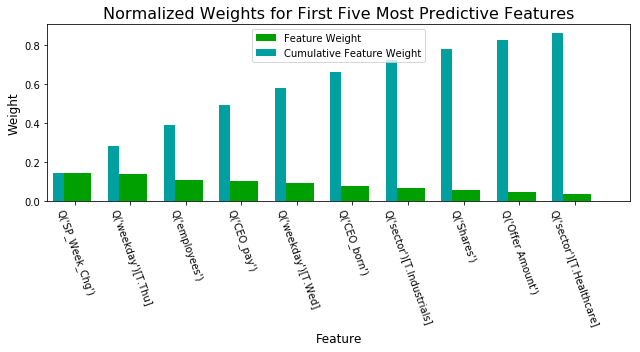

In [53]:
#feature importances for the last model used - here AdaBoost
f_importances = clf.feature_importances_
feature_plot(f_importances, X_train, y_train);

Conclusion: from the plot above we can see that the 5 most important features are broad market conditions, offer amount, CEO_pay, number of employees and number of shares. 

# Conclusion:

Among the 4 models tested here, **AdaBoost** performed the best (others are GradientBoost, Logistic and RandomForest). Although it has the second highest precision score 0.84 after Logistic Regression with precision score of 0.88, its other metrics - recall score and accuracy score - are much higher than those of Logistic Regression (recall score: 0.73 vs 0.6; accuracy score: 0.69 vs 0.63).
<br><br>
When considering returns on "successes" (as opposite to failures), we also get the highest returns with the AdaBoost - \\$41.98 (vs GB=\\$26.28, RF=\\$27.53 , Logistic=\\$35.17). <br>
It's not the highest possible amount that we could have earned if we could have predicted all successful IPOs correctly - \\$85.99, which is practically impossible. Still it is much better outcome than naive approach, when investing in each and every IPO. In this case, the returns would have been negative or \\$-34.09.

In general, all tested models performed much better than the naive approach and so could help avoid losing money by investing in unsuccessful IPOs (although this conclusion is limited by the definition of 'success' as provided here - i.e. IPO's price should change by more than $1 on its first day of trading).